In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from functools import reduce
import scipy.optimize as opt

In [2]:
headers = ['date', 'w5000']
w5000 = pd.read_csv('WILL5000INDFC.csv', header=None, names=headers, skiprows=1)
w5000['date'] = pd.to_datetime(w5000['date'])
w5000.set_index('date', inplace=True)
w5000['w5000'] = pd.to_numeric(w5000['w5000'], errors='coerce')

In [3]:
pce = pd.read_csv('PCECC96.csv')
pce.columns = ['date', 'pce']
pce.set_index('date', inplace=True)
pce['pce'] = pd.to_numeric(pce['pce'], errors='coerce')

In [4]:
gdpdef = pd.read_csv('GDPDEF.csv')
gdpdef.columns = ['date', 'gdp_deflate']
gdpdef.set_index('date', inplace=True)
gdpdef['gdp_deflate'] = pd.to_numeric(gdpdef['gdp_deflate'], errors='coerce')

In [5]:
headers = ['date', 'tb3m']
tb3m = pd.read_csv('TB3MS.csv', header=None, names=headers, skiprows=1)
tb3m['date'] = pd.to_datetime(tb3m['date'])
tb3m.set_index('date', inplace=True)
tb3m['tb3m'] = pd.to_numeric(tb3m['tb3m'], errors='coerce')

In [7]:
w5000 = w5000.resample('D').asfreq()
w5000 = w5000.fillna(method='ffill')
w5000 = w5000.resample('Q').asfreq()
tb3m = tb3m.resample('D').asfreq()
tb3m = tb3m.fillna(method='ffill')
tb3m = tb3m.resample('Q').asfreq()
w5000.index = w5000.index + pd.DateOffset(1)
tb3m.index = tb3m.index + pd.DateOffset(1)

In [11]:
dfs = [w5000, pce, gdpdef, tb3m]
df = reduce(lambda df1, df2: df1.merge(df2, "outer", left_index=True, right_index=True), dfs)
df = df.dropna(axis=0)
df['w5000_r'] = df['w5000'] / (df['gdp_deflate'] / 100)
df['w5000_r_return'] = df['w5000_r'] / df['w5000_r'].shift(1)
df['tb3m'] = df['tb3m']/100 + 1
df.head()
df.dropna(axis=0, inplace=True)

**EXERCISE 1**

In [36]:
def object_fun(gamma, df):
    
    beta = 0.99
    
    mu = df.pce ** (-gamma)
    m = beta * mu / mu.shift(1)
    R = df.w5000_r_return
    m  = m[1:]
    R = R[1:]
    cov = np.cov(m, R)[0, 1]
    obj = (1 - cov - m.mean() * R.mean())
        
    return obj

In [37]:
fun = lambda gamma: object_fun(gamma, df)
gamma = opt.broyden1(fun, 1)
print(gamma)

1.4882640468217236


**EXERCISE 2**

Barro and Jin (2011) estimate gamma to be close to 3, with a 95% confidence interval of 2 to 4. Gandelman and Hernandez-Murillo (2014), in their turn, find individual country estimates ranging from 0 to 3, with an average of 0.98. Their Wald tests indicate that the coefficient of relative risk aversion is smaller than 2 for the vast majority of countries and in the vicinity of 1.
Our estimate seems more in line with the latter.

**EXERCISE 3**

In [38]:
def object_fun2(gamma, df):
    
    beta = 0.99
    
    mu = df.pce ** (-gamma)
    m = beta * mu / mu.shift(1)
    m  = m[1:]
    rp1 = df.tb3m[1:]
    err = rp1 - 1 / np.mean(m) 
    obj = np.sum(err ** 2)
    
    return obj

In [54]:
fun2 = lambda gamma: object_fun2(gamma, df)
gamma = opt.broyden1(fun2, 1)
print(gamma)

NoConvergence: -0.053496294273851074

In [56]:
fun2 = lambda gamma: object_fun2(gamma, df)
gamma = opt.minimize(fun2, 1, method='TNC')
print(gamma)

     fun: 0.00117860235812725
     jac: array([-1.29258583e-07])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 15
     nit: 3
  status: 1
 success: True
       x: array([-0.08054473])


In [45]:
fun2 = lambda gamma: object_fun2(gamma, df)
gamma = opt.minimize(fun2, 1, method='Powell')
print(gamma)

   direc: array([[-0.00165604]])
     fun: 0.0011786023529411825
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 2
  status: 0
 success: True
       x: array(-0.08046449)


In [60]:
fun2 = lambda gamma: object_fun2(gamma, df)
gamma = opt.root(fun2, 1) #,method='broyden1'
print(gamma)

    fjac: array([[-1.]])
     fun: 0.001178603416070574
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 21
     qtf: array([-0.0011786])
       r: array([5.65411278e-06])
  status: 5
 success: False
       x: array([-0.08161345])


**EXERCISE 4**

In [81]:
def object_fun3(coeff, df):
    gamma, beta = coeff
    
    moms = np.empty(2)
    W = np.eye(2)
    
    mu = df.pce ** (-gamma)
    m = beta * mu / mu.shift(1)
    R = df.w5000_r_return
    m  = m[1:]
    R = R[1:]
        
    cov = np.cov(m, R)[0, 1]
    moms[0] = (1 - cov - m.mean() * R.mean())
            
    rp1 = df.tb3m[1:]
    err = rp1 - 1 / np.mean(m) 
    moms[1] = np.sum(err ** 2)
        
    err = moms.T @ W @ moms
        
    return err

In [106]:
fun3 = lambda coeff: object_fun3(coeff, df)
#coeff = opt.broyden1(fun3, [1, 1])
#coeff = opt.root(fun3, [1, 1])
#coeff = opt.minimize(fun3, [1, 1], method='TNC')
#print(coeff)

coeff = opt.minimize(fun3, [1, 1], method='Powell')
#print(coeff)
print("gamma:", coeff.x[0])
print("beta:", coeff.x[1])

gamma: 2.8142799960528917
beta: 1.0000076154239756


When estimating both parameters simultaneously, the value found for the rate of relative risk aversion differs substantially from both of my previous estimates (and across optimization routines). Overall, it falls in between the previous two estimates. Consequently, the results do not seem very robust.

In [113]:
n = 5
N = 5
gamma_grid = np.linspace(1, 5, n)
beta_grid = np.linspace(0.95, 0.99, N)

estimates = np.empty((n, N))
for ii in range(n):
    for jj in range(N):
        estimates[ii, jj] = object_fun3([gamma_grid[ii], beta_grid[jj]], df)

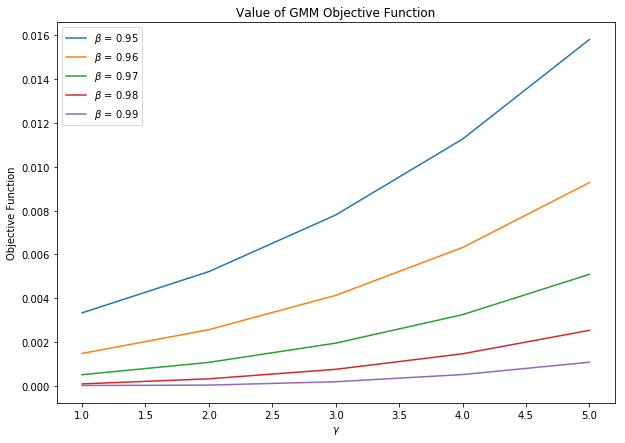

In [114]:
plt.figure(figsize=(10, 7))
for jj in range(N):
    plt.plot(gamma_grid, estimates[:, jj], label=rf'$\beta$ = {beta_grid[jj]:.2f}')
plt.title('Value of GMM Objective Function')
plt.xlabel('$\gamma$')
plt.ylabel('Objective Function')
plt.legend()
plt.show()